In [60]:
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
from torch_geometric.data import Data, InMemoryDataset
import torch_geometric
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import random
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:


def set_device_and_seed(GPU=True, seed=0, gpu_name = "cuda:0"):
    torch.cuda.is_available()
    if GPU:
        device = torch.device(gpu_name if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device("cpu")
    print(f'Using {device}')

    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        
    set_seed(seed)
    
    return device

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    print(f"Setting torch, cuda, numpy and random seeds to {seed}")


def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

    
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [3]:
# Setting random seed and device
GPU = True # Choose whether to use GPU
set_device_and_seed(GPU=True, seed=0, gpu_name='cuda')

Using cuda
Setting torch, cuda, numpy and random seeds to 0


device(type='cuda')

### Load Data


In [4]:
pilot_df = pd.read_excel(os.path.abspath("/home/sneha/airway_tree_pilot.xlsx"), sheet_name=0)
pilot_df.drop(columns = ["manufacturer", "model"], inplace=True)

In [5]:
label_df = pd.read_csv(os.path.abspath("/home/sneha/MESA_Exam5_airway_variants.csv"))

In [6]:
label_df.sum()

idno                                                  17397820297
LL_1            StandardStandardStandardStandardStandardAcc. B...
Standard                                                     2304
Acc_B                                                         455
Abs_RB7                                                       175
Acc_LB7                                                        53
Rare                                                            2
Unclassified                                                  185
dtype: object

In [7]:
pilot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77683 entries, 0 to 77682
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idno               77683 non-null  int64  
 1   anatomicalname     77683 non-null  object 
 2   startbpid          77683 non-null  int64  
 3   endbpid            77683 non-null  int64  
 4   centerlinelength   77683 non-null  float64
 5   angle              77454 non-null  float64
 6   dircosx            77683 non-null  float64
 7   dircosy            77683 non-null  float64
 8   dircosz            77683 non-null  float64
 9   avginnerarea       77683 non-null  float64
 10  lobes              77683 non-null  object 
 11  generation         77683 non-null  int64  
 12  weibel_generation  77683 non-null  int64  
dtypes: float64(6), int64(5), object(2)
memory usage: 7.7+ MB


## Make a tiny graph sample & visualise in networkx

In [38]:
single_test = pilot_df[(pilot_df.idno ==3011950) & (pilot_df.weibel_generation <= 3)].copy().reset_index().drop(columns='index')
single_test.fillna(0, inplace=True)


In [39]:
# NODE FEATURES ARE WRONG!!!
single_test['x_diff'] = (single_test.centerlinelength*single_test.dircosx)
single_test['y_diff'] = (single_test.centerlinelength*single_test.dircosy)
single_test['z_diff'] = (single_test.centerlinelength*single_test.dircosz)

single_test

,idno,anatomicalname,startbpid,endbpid,centerlinelength,angle,dircosx,dircosy,dircosz,avginnerarea,lobes,generation,weibel_generation,x_diff,y_diff,z_diff
0,3011950,Trachea,-1,1,82.03930,0.0000,-0.012990,0.194850,0.980747,237.7040,CEN,0,0,-1.065691,15.985358,80.459797
1,3011950,RMB,1,6,23.64560,144.8070,-0.498729,-0.142494,0.854965,140.5670,CEN,1,1,-11.792746,-3.369356,20.216160
2,3011950,LMB,1,7,50.79000,127.0430,0.787070,0.049192,0.614899,97.7085,CEN,1,1,39.975285,2.498457,31.230720
3,3011950,BronInt,6,19,19.75500,162.0700,-0.260820,0.026082,0.965035,108.4940,CEN,2,2,-5.152499,0.515250,19.064266
4,3011950,RUL,6,18,13.97160,98.7818,-0.904762,-0.190476,-0.380952,60.5322,RUL,2,2,-12.640973,-2.661254,-5.322509
5,3011950,LUL,7,11,12.09850,115.3660,0.832050,-0.443760,-0.332820,60.5433,LUL,2,2,10.066557,-5.368830,-4.026623
6,3011950,LLB6,7,10,8.43446,165.4590,0.745356,0.298142,0.596285,146.8000,LLL,2,2,6.286675,2.514667,5.029342
7,3011950,LLB,10,15,9.92149,161.2140,0.577350,0.115470,0.808290,40.2393,LLL,3,3,5.728172,1.145634,8.019441
8,3011950,LB6,10,14,8.46466,114.7760,0.401610,0.883541,-0.240966,24.9217,LLL,3,3,3.399492,7.478874,-2.039695
9,3011950,-,11,17,10.52590,147.6560,0.498464,-0.387694,-0.775388,38.2976,LUL,3,3,5.246782,-4.080828,-8.161657


In [44]:
# lambda row: row.x_diff + single_test.loc[single_test.endbpid == row.startbpid][]
# get in numpy
def _get_coords(single_test):
    x_diff= (single_test.centerlinelength*single_test.dircosx).values
    y_diff = (single_test.centerlinelength*single_test.dircosy).values
    z_diff = (single_test.centerlinelength*single_test.dircosz).values
    endbpid = single_test.endbpid.values
    startbpid = single_test.startbpid.values
    x = np.zeros_like(x_diff)
    y = np.zeros_like(x_diff)
    z = np.zeros_like(x_diff)
    for i in range(len(x_diff)):
        if startbpid[i] == -1:
            x[i] = x_diff[i] + 0
            y[i] = y_diff[i] + 0
            z[i] = z_diff[i] + 0
        else:
            # find parent id
            parent = np.where(endbpid == startbpid[i])
            x[i] = x_diff[i] + x[parent] 
            y[i] = y_diff[i] + y[parent] 
            z[i] = z_diff[i] + z[parent] 
    # put into dataframe
    coords_df = pd.DataFrame({"x": x, "y": y, "z":z})
    
    return single_test.join(coords_df, how="left")

    
single_test = _get_coords(single_test)
print(single_test)



ValueError: columns overlap but no suffix specified: Index(['x', 'y', 'z'], dtype='object')

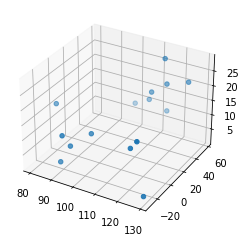

In [49]:

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter(single_test.z, single_test.x, single_test.y, 'green')

In [50]:
# nodes and features: TODO include all features relevant + NORMALISE
nodes = list(zip(single_test.endbpid, single_test[['x', 'y', 'z','weibel_generation', 'angle']].to_dict(orient='records')))
nodes =[(-1,
  {'x': 0,
   'y': 0,
   'z': 0,
   'weibel_generation': -1,
   'angle': 0.0})]+nodes

In [51]:
# edges and features: TODO include all features relevant + NORMALISE
edges = list(zip(single_test.startbpid, single_test.endbpid))
edges_with_features = dict(zip(edges,single_test[['centerlinelength', 'avginnerarea']].to_dict(orient='records')))
edges_with_features

{(-1, 1): {'centerlinelength': 82.0393, 'avginnerarea': 237.704},
 (1, 6): {'centerlinelength': 23.6456, 'avginnerarea': 140.567},
 (1, 7): {'centerlinelength': 50.79, 'avginnerarea': 97.7085},
 (6, 19): {'centerlinelength': 19.755, 'avginnerarea': 108.494},
 (6, 18): {'centerlinelength': 13.9716, 'avginnerarea': 60.5322},
 (7, 11): {'centerlinelength': 12.0985, 'avginnerarea': 60.5433},
 (7, 10): {'centerlinelength': 8.43446, 'avginnerarea': 146.8},
 (10, 15): {'centerlinelength': 9.92149, 'avginnerarea': 40.2393},
 (10, 14): {'centerlinelength': 8.46466, 'avginnerarea': 24.9217},
 (11, 17): {'centerlinelength': 10.5259, 'avginnerarea': 38.2976},
 (11, 16): {'centerlinelength': 11.1299, 'avginnerarea': 28.5548},
 (18, 28): {'centerlinelength': 7.33379, 'avginnerarea': 42.1697},
 (18, 29): {'centerlinelength': 6.53103, 'avginnerarea': 36.133},
 (19, 30): {'centerlinelength': 18.0194, 'avginnerarea': 34.9124},
 (19, 31): {'centerlinelength': 6.1641, 'avginnerarea': 77.5104}}

[(-1, 1, {'centerlinelength': 82.0393, 'avginnerarea': 237.704}), (1, 6, {'centerlinelength': 23.6456, 'avginnerarea': 140.567}), (1, 7, {'centerlinelength': 50.79, 'avginnerarea': 97.7085}), (6, 19, {'centerlinelength': 19.755, 'avginnerarea': 108.494}), (6, 18, {'centerlinelength': 13.9716, 'avginnerarea': 60.5322}), (7, 11, {'centerlinelength': 12.0985, 'avginnerarea': 60.5433}), (7, 10, {'centerlinelength': 8.43446, 'avginnerarea': 146.8}), (19, 30, {'centerlinelength': 18.0194, 'avginnerarea': 34.9124}), (19, 31, {'centerlinelength': 6.1641, 'avginnerarea': 77.5104}), (18, 28, {'centerlinelength': 7.33379, 'avginnerarea': 42.1697}), (18, 29, {'centerlinelength': 6.53103, 'avginnerarea': 36.133}), (11, 17, {'centerlinelength': 10.5259, 'avginnerarea': 38.2976}), (11, 16, {'centerlinelength': 11.1299, 'avginnerarea': 28.5548}), (10, 15, {'centerlinelength': 9.92149, 'avginnerarea': 40.2393}), (10, 14, {'centerlinelength': 8.46466, 'avginnerarea': 24.9217})]
[(-1, {'x': 0, 'y': 0, 'z

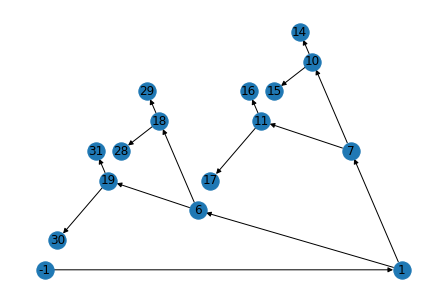

In [52]:
g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
nx.set_edge_attributes(g,edges_with_features)
print(g.edges(data=True))
print(g.nodes(data=True))
# 2D projection of tree (excluding the trachea itself)
nx.draw_planar(g,with_labels=True)

## Pytorch Dataset for Geometric

In [53]:
x_list_plus_trachea = [[0,0,0,-1]]+ single_test.apply(lambda row:row[['x','y','z', 'weibel_generation']].to_list(), axis=1).to_list() # here only node features are pos and weibel gen
x = torch.tensor(x_list_plus_trachea, dtype=torch.float)
x.shape

torch.Size([16, 4])

In [54]:
# edges
# relabel_map = dict(zip(single_test.endbpid,np.arange(1,len(single_test))))
relabel_map = {v:k+1 for k,v in single_test.endbpid.to_dict().items()}
# single_test.startbpid.apply(lambda x: if x== -1 relabel_map[x])
relabel_map[-1] = 0
relabel_map
source_nodes = single_test.startbpid.apply(lambda x: relabel_map[x]).to_list()
end_nodes = single_test.endbpid.apply(lambda x: relabel_map[x]).to_list()
source_nodes, end_nodes

([0, 1, 1, 2, 2, 3, 3, 7, 7, 6, 6, 5, 5, 4, 4],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [55]:
edge_index = torch.tensor([source_nodes, end_nodes], dtype=torch.long)
edge_index.shape

torch.Size([2, 15])

In [56]:
data = Data(x=x, y=torch.FloatTensor([0]),edge_index=edge_index)

In [57]:
data

Data(x=[16, 4], edge_index=[2, 15], y=[1])

In [282]:
nodes = torch.tensor([0,0,0,-1]+ x )

TypeError: can only concatenate list (not "Tensor") to list

OutEdgeView([(0, 1), (1, 2), (1, 3), (2, 4), (2, 5), (3, 6), (3, 7), (4, 14), (4, 15), (5, 12), (5, 13), (6, 10), (6, 11), (7, 8), (7, 9)])

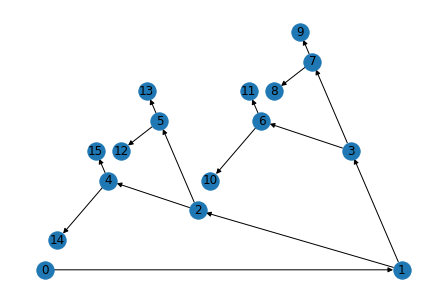

In [283]:
import torch_geometric
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
nx.draw_planar(g, with_labels=True)
g.edges()


In [102]:
label_df = pd.read_csv(os.path.abspath("/home/sneha/MESA_Exam5_airway_variants.csv"))

from collections import Counter
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(label_df.LL_1)
label_df['LL_1_encoded'] = le.transform(label_df.LL_1)

idno = 3010007

torch.tensor(label_df.loc[label_df.idno==idno,
             'LL_1_encoded'].values, dtype=torch.int64)


tensor([4])

In [87]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

def _get_edge_adjacency(df):
    # NOTE pytorch requires nodes to start from 0 and go up in integers so need to remap start and end bpids from df
    relabel_map = {v:k+1 for k,v in df.endbpid.to_dict().items()}
    # add trachea map (node 0)
    relabel_map[-1] = 0
    print("relabel", relabel_map)
    # apply relabelling to source and end nodes
    source_nodes = df.startbpid.apply(lambda x: relabel_map[x]).to_list()
    end_nodes = df.endbpid.apply(lambda x: relabel_map[x]).to_list()
    # return in COO format
    return torch.tensor([source_nodes, end_nodes], dtype=torch.long)

def _get_node_features(df):
    df_w_coords = _get_coords(df)
    # add trachea to nodes
    # currently usnig as features 
    x_list_plus_trachea = [[0,0,0,-1]]+ df_w_coords.apply(lambda row:row[['x','y','z', 'weibel_generation']].to_list(), axis=1).to_list() # here only node features are pos and weibel gen
    x = torch.tensor(x_list_plus_trachea, dtype=torch.float)
    # normalise features
    scaler = StandardScaler()
    scaler.fit(x)
    x_norm = scaler.transform(x)
    return torch.tensor(x_norm, dtype=torch.float)

def _get_edge_features(df):
    # get matrix of shape [# edges, edge feature size]
    edge_features = df[['centerlinelength', 'avginnerarea']].values
    # normalise
    scaler = StandardScaler()
    scaler.fit(edge_features)
    edge_norm = scaler.transform(edge_features)
    return torch.tensor(edge_norm, dtype=torch.float)
    
def _get_label(idno, label_df):
    return torch.tensor(label_df.loc[label_df.idno==idno,
             'LL_1_encoded'].values, dtype=torch.int64)


full_pilot = pd.read_csv('/home/sneha/airway_tree_pilot_clean.csv')
label_df = pd.read_csv(os.path.abspath("/home/sneha/MESA_Exam5_airway_variants.csv"))
le = LabelEncoder()
le.fit(label_df.LL_1)
label_df['LL_1_encoded'] = le.transform(label_df.LL_1)
graph_ids = full_pilot.idno.unique()
for i, idno in tqdm(list(enumerate(graph_ids))[:2]):
    # iterate through each patricipant
    df = full_pilot.loc[full_pilot.idno == idno].copy().reset_index()
    # build a graph out of the df with node features, edge_features and edge_adjacency
    print(df.info())
    x = _get_node_features(df)
    edge_adjacency = _get_edge_adjacency(df)
    edge_features = _get_edge_features(df)
    y = _get_graph_label(idno)
    data = Data(x=x,
                edge_index=edge_adjacency,
                edge_attr = edge_features,
                y = y
               )
    if self.test:
        torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
    else:
         torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))
                


 50%|██████████████████████████████████████████▌                                          | 1/2 [00:00<00:00,  7.17it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              285 non-null    int64  
 1   idno               285 non-null    int64  
 2   anatomicalname     285 non-null    object 
 3   startbpid          285 non-null    int64  
 4   endbpid            285 non-null    int64  
 5   centerlinelength   285 non-null    float64
 6   angle              284 non-null    float64
 7   dircosx            285 non-null    float64
 8   dircosy            285 non-null    float64
 9   dircosz            285 non-null    float64
 10  avginnerarea       285 non-null    float64
 11  lobes              285 non-null    object 
 12  generation         285 non-null    int64  
 13  weibel_generation  285 non-null    int64  
 14  manufacturer       285 non-null    object 
 15  model              285 non-null    object 
dtypes: float64(6), int64(6), o

100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]

relabel {1: 1, 2: 2, 3: 3, 5: 4, 4: 5, 14: 6, 7: 7, 15: 8, 16: 9, 10: 10, 11: 11, 37: 12, 38: 13, 17: 14, 18: 15, 20: 16, 19: 17, 23: 18, 41: 19, 24: 20, 26: 21, 25: 22, 27: 23, 28: 24, 29: 25, 30: 26, 32: 27, 31: 28, 33: 29, 34: 30, 36: 31, 35: 32, 39: 33, 40: 34, 43: 35, 42: 36, 44: 37, 45: 38, 47: 39, 46: 40, 48: 41, 49: 42, 50: 43, 51: 44, 52: 45, 53: 46, 54: 47, 55: 48, 57: 49, 56: 50, 58: 51, 59: 52, 61: 53, 60: 54, 62: 55, 63: 56, 64: 57, 65: 58, 66: 59, 67: 60, 68: 61, 69: 62, 71: 63, 70: 64, 73: 65, 72: 66, 74: 67, 75: 68, 76: 69, 77: 70, 78: 71, 79: 72, 80: 73, 81: 74, 82: 75, 83: 76, 84: 77, 85: 78, 87: 79, 86: 80, 88: 81, 89: 82, 90: 83, 91: 84, 92: 85, 93: 86, 94: 87, 95: 88, 96: 89, 97: 90, 98: 91, 99: 92, 100: 93, 101: 94, 102: 95, 103: 96, 104: 97, 105: 98, 106: 99, 107: 100, 108: 101, 109: 102, 110: 103, 111: 104, 112: 105, 113: 106, 114: 107, 115: 108, 117: 109, 116: 110, 119: 111, 118: 112, 120: 113, 121: 114, 123: 115, 122: 116, 124: 117, 125: 118, 126: 119, 127: 12

In [121]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
# https://www.youtube.com/watch?v=QLIkOtKS4os --> creating custom dataset in pytorch geometric


class CustomDataset(Dataset):
    def __init__(self,root, filename_data, filename_labels, test=False, transform=None, pre_transform=None):
        '''
        root = where dataset should be stored, folder is split into raw_dir and processed_dir
        '''
        self.test = test
        self.filename_data = filename_data
        self.filename_labels = filename_labels
        super(CustomDataset, self).__init__(root, transform, pre_transform)
        
        

    @property
    def raw_file_names(self):
        return self.filename_data
    
    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
    
    def _download(self):
        pass
    
    def process(self):
        self.data = pd.read_csv(os.path.abspath(self.raw_paths[0]))
        label_df = pd.read_csv(os.path.abspath(self.filename_labels))
        le = LabelEncoder()
        le.fit(label_df.LL_1)
        label_df['LL_1_encoded'] = le.transform(label_df.LL_1)
        graph_ids = self.data.idno.unique()
        for i, idno in tqdm(list(enumerate(graph_ids))):
            # iterate through each patricipant
            df = self.data.loc[self.data.idno == idno].copy().reset_index()
            # build a graph out of the df with node features, edge_features and edge_adjacency
            x = self._get_node_features(df)
            edge_adjacency = self._get_edge_adjacency(df)
            edge_features = self._get_edge_features(df)
            y = self._get_label(idno, label_df)
            data = Data(x=x,
                        edge_index=edge_adjacency,
                        edge_attr = edge_features,
                        y = y
                       )
            if self.test:
                torch.save(data, 
                            os.path.join(self.processed_dir, 
                                         f'data_test_{i}.pt'))
            else:
                 torch.save(data, 
                            os.path.join(self.processed_dir, 
                                         f'data_{i}.pt'))
        
    def _get_edge_adjacency(self,df):
        # NOTE pytorch requires nodes to start from 0 and go up in integers so need to remap start and end bpids from df
        relabel_map = {v:k+1 for k,v in df.endbpid.to_dict().items()}
        # add trachea map (node 0)
        relabel_map[-1] = 0
        # apply relabelling to source and end nodes
        source_nodes = df.startbpid.apply(lambda x: relabel_map[x]).to_list()
        end_nodes = df.endbpid.apply(lambda x: relabel_map[x]).to_list()
        # return in COO format
        return torch.tensor([source_nodes, end_nodes], dtype=torch.long)

    def _get_node_features(self,df):
        df_w_coords = _get_coords(df)
        # add trachea to nodes
        # currently usnig as features 
        x_list_plus_trachea = [[0,0,0,-1]]+ df_w_coords.apply(lambda row:row[['x','y','z', 'weibel_generation']].to_list(), axis=1).to_list() # here only node features are pos and weibel gen
        x = torch.tensor(x_list_plus_trachea, dtype=torch.float)
        # normalise features
        scaler = StandardScaler()
        scaler.fit(x)
        x_norm = scaler.transform(x)
        return torch.tensor(x_norm, dtype=torch.float)

    def _get_edge_features(self,df):
        # get matrix of shape [# edges, edge feature size]
        edge_features = df[['centerlinelength', 'avginnerarea']].values
        # normalise
        scaler = StandardScaler()
        scaler.fit(edge_features)
        edge_norm = scaler.transform(edge_features)
        return torch.tensor(edge_norm, dtype=torch.float)

    def _get_label(self, idno, label_df):
        return torch.tensor(label_df.loc[label_df.idno==idno,
                 'LL_1_encoded'].values, dtype=torch.int64)
    
    def len(self):
        return int(self.data.idno.nunique())
    
    def get(self, idx):
        '''
        Equivalent to __getitem__ in pytorch
        '''
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data
            

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
        
my_data  = CustomDataset(
    root='data/', 
    filename_data= '/home/sneha/airway_tree_pilot_clean.csv',
    filename_labels = "/home/sneha/MESA_Exam5_airway_variants.csv")

Processing...
100%|█████████████████████████████████████████████████████████████████████████████████| 227/227 [00:38<00:00,  5.92it/s]
Done!


In [123]:
train_loader = DataLoader(my_data, batch_size=16, shuffle=True)

In [172]:
m = nn.Softmax()
input = torch.randn(2, 3)
print(input)
print(m(input))
m(input).argmax(dim=1)

tensor([[-1.5055, -0.6610,  1.3232],
        [ 0.0371, -0.2849, -0.1334]])
tensor([[0.0494, 0.1149, 0.8357],
        [0.3894, 0.2822, 0.3284]])


/tmp/ipykernel_17836/4204858206.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(m(input))
/tmp/ipykernel_17836/4204858206.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  m(input).argmax(dim=1)


tensor([2, 0])

In [131]:
i, data = next(enumerate(train_loader))
data.num_graphs

16

In [206]:


class GCN(torch.nn.Module):
    def __init__(self,in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return torch.tensor(x)

def _count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad == True)
    
model = GCN(in_channels=4, hidden_channels=8, out_channels=6)
print(model)
print(list(model.parameters()))

GCN(
  (conv1): GCNConv(4, 8)
  (conv2): GCNConv(8, 8)
  (conv3): GCNConv(8, 8)
  (lin): Linear(in_features=8, out_features=6, bias=True)
)
[Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[-0.2659, -0.1007, -0.3153, -0.0881],
        [ 0.6361, -0.6798, -0.3345,  0.6009],
        [-0.0372, -0.1469,  0.2378, -0.2987],
        [ 0.2904, -0.4362, -0.2126,  0.5412],
        [ 0.0693, -0.5593,  0.4248, -0.4699],
        [-0.0456, -0.0020, -0.3116,  0.3165],
        [-0.0699,  0.3861,  0.3593, -0.5530],
        [ 0.5281,  0.0176,  0.5583,  0.4401]], requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[-0.3485,  0.2862, -0.5823, -0.2902,  0.2441,  0.5731,  0.3985,  0.2532],
        [-0.4325,  0.1859, -0.2230,  0.0355, -0.0784,  0.5731,  0.3995,  0.0641],
        [-0.5954,  0.4798,  0.4201,  0.2081, -0.6052, -0.4069,  0.3224, -0.5745],
        [ 0

In [190]:
loss = nn.CrossEntropyLoss()
input_ = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
print(input)
print(target)
loss(input_, target)

tensor([[-1.5055, -0.6610,  1.3232],
        [ 0.0371, -0.2849, -0.1334]])
tensor([3, 4, 1])


tensor(2.6879, grad_fn=<NllLossBackward0>)

Using cuda:0
Setting torch, cuda, numpy and random seeds to 0


  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.03it/s]


Epoch: 0, Loss: 1.82


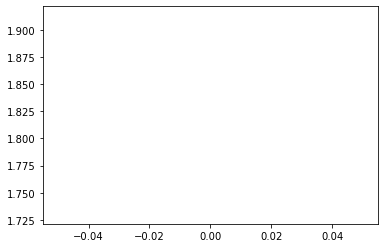

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.29it/s]


Epoch: 1, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.63it/s]


Epoch: 2, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.75it/s]


Epoch: 3, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.18it/s]


Epoch: 4, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.63it/s]


Epoch: 5, Loss: 1.83


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.78it/s]


Epoch: 6, Loss: 1.83


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.82it/s]


Epoch: 7, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.73it/s]


Epoch: 8, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.67it/s]


Epoch: 9, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.70it/s]


Epoch: 10, Loss: 1.81


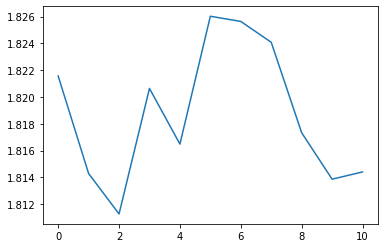

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.54it/s]


Epoch: 11, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.21it/s]


Epoch: 12, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.90it/s]


Epoch: 13, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.08it/s]


Epoch: 14, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.12it/s]


Epoch: 15, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.60it/s]


Epoch: 16, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.25it/s]


Epoch: 17, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.64it/s]


Epoch: 18, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.75it/s]


Epoch: 19, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.42it/s]


Epoch: 20, Loss: 1.82


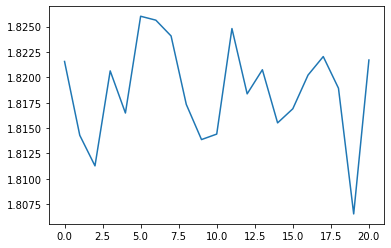

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.48it/s]


Epoch: 21, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 48.36it/s]


Epoch: 22, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.24it/s]


Epoch: 23, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.37it/s]


Epoch: 24, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.25it/s]


Epoch: 25, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.95it/s]


Epoch: 26, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.43it/s]


Epoch: 27, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.88it/s]


Epoch: 28, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.71it/s]


Epoch: 29, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.45it/s]


Epoch: 30, Loss: 1.81


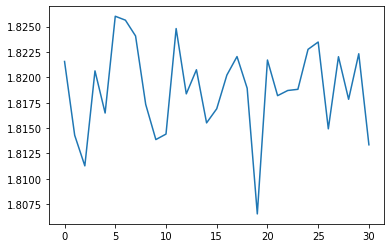

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.16it/s]


Epoch: 31, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.49it/s]


Epoch: 32, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.04it/s]


Epoch: 33, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.00it/s]


Epoch: 34, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.15it/s]


Epoch: 35, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.90it/s]


Epoch: 36, Loss: 1.83


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.40it/s]


Epoch: 37, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.86it/s]


Epoch: 38, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.25it/s]


Epoch: 39, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.35it/s]


Epoch: 40, Loss: 1.82


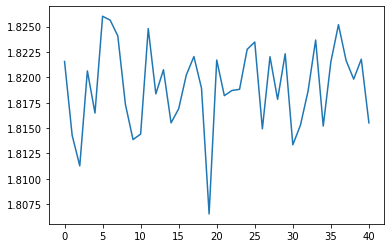

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.01it/s]


Epoch: 41, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.02it/s]


Epoch: 42, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.83it/s]


Epoch: 43, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.31it/s]


Epoch: 44, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.66it/s]


Epoch: 45, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.90it/s]


Epoch: 46, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.13it/s]


Epoch: 47, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 48.66it/s]


Epoch: 48, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.46it/s]


Epoch: 49, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.10it/s]


Epoch: 50, Loss: 1.81


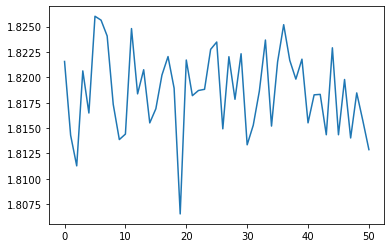

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 20.50it/s]


Epoch: 51, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.45it/s]


Epoch: 52, Loss: 1.83


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.30it/s]


Epoch: 53, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.61it/s]


Epoch: 54, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.02it/s]


Epoch: 55, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.52it/s]


Epoch: 56, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.97it/s]


Epoch: 57, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.95it/s]


Epoch: 58, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.82it/s]


Epoch: 59, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.36it/s]


Epoch: 60, Loss: 1.81


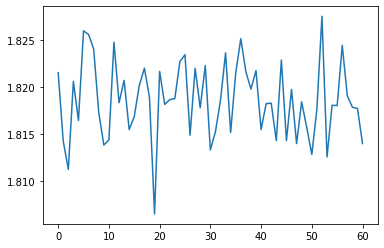

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.47it/s]


Epoch: 61, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.02it/s]


Epoch: 62, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.21it/s]


Epoch: 63, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.26it/s]


Epoch: 64, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.60it/s]


Epoch: 65, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.69it/s]


Epoch: 66, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.20it/s]


Epoch: 67, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.31it/s]


Epoch: 68, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.49it/s]


Epoch: 69, Loss: 1.83


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.39it/s]


Epoch: 70, Loss: 1.82


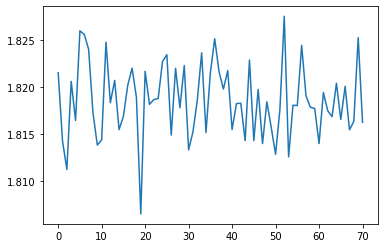

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.69it/s]


Epoch: 71, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.06it/s]


Epoch: 72, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.39it/s]


Epoch: 73, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.14it/s]


Epoch: 74, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.34it/s]


Epoch: 75, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.25it/s]


Epoch: 76, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.00it/s]


Epoch: 77, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.75it/s]


Epoch: 78, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.98it/s]


Epoch: 79, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.33it/s]


Epoch: 80, Loss: 1.83


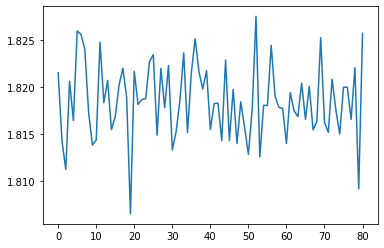

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.81it/s]


Epoch: 81, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.25it/s]


Epoch: 82, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.83it/s]


Epoch: 83, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.42it/s]


Epoch: 84, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.09it/s]


Epoch: 85, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.02it/s]


Epoch: 86, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.92it/s]


Epoch: 87, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 48.43it/s]


Epoch: 88, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 32.75it/s]


Epoch: 89, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.08it/s]

Epoch: 90, Loss: 1.82


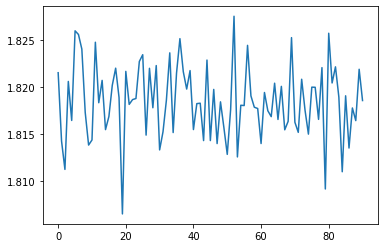

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.94it/s]


Epoch: 91, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.64it/s]


Epoch: 92, Loss: 1.83


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.31it/s]


Epoch: 93, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.52it/s]


Epoch: 94, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.81it/s]


Epoch: 95, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.78it/s]


Epoch: 96, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.29it/s]


Epoch: 97, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.76it/s]


Epoch: 98, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 48.29it/s]


Epoch: 99, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.05it/s]

Epoch: 100, Loss: 1.82


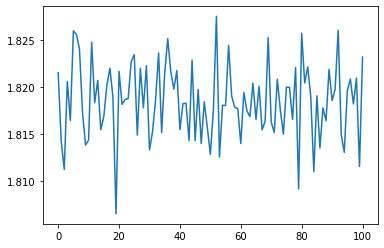

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.20it/s]


Epoch: 101, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.98it/s]


Epoch: 102, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.03it/s]


Epoch: 103, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.94it/s]


Epoch: 104, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.42it/s]


Epoch: 105, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.51it/s]


Epoch: 106, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 48.06it/s]


Epoch: 107, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.12it/s]


Epoch: 108, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.27it/s]


Epoch: 109, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.40it/s]


Epoch: 110, Loss: 1.82


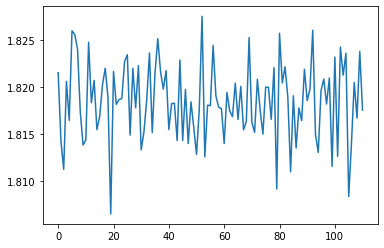

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.47it/s]


Epoch: 111, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.67it/s]


Epoch: 112, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.52it/s]


Epoch: 113, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.83it/s]


Epoch: 114, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.63it/s]


Epoch: 115, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.88it/s]


Epoch: 116, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.97it/s]


Epoch: 117, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.59it/s]


Epoch: 118, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.70it/s]


Epoch: 119, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.32it/s]

Epoch: 120, Loss: 1.81


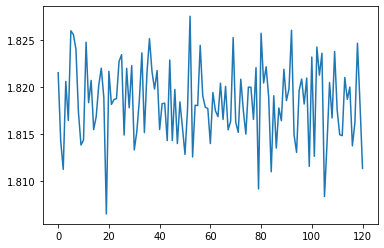

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.91it/s]


Epoch: 121, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.07it/s]


Epoch: 122, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.50it/s]


Epoch: 123, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.30it/s]


Epoch: 124, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.28it/s]


Epoch: 125, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.84it/s]


Epoch: 126, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.56it/s]


Epoch: 127, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.45it/s]


Epoch: 128, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.67it/s]


Epoch: 129, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.17it/s]


Epoch: 130, Loss: 1.82


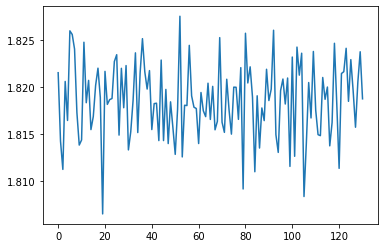

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.28it/s]


Epoch: 131, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.75it/s]


Epoch: 132, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.79it/s]


Epoch: 133, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.93it/s]


Epoch: 134, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.76it/s]


Epoch: 135, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.44it/s]


Epoch: 136, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.68it/s]


Epoch: 137, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.63it/s]


Epoch: 138, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.04it/s]


Epoch: 139, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.57it/s]


Epoch: 140, Loss: 1.82


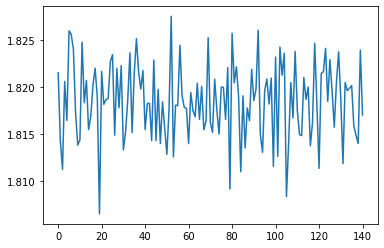

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.00it/s]


Epoch: 141, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.04it/s]


Epoch: 142, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.35it/s]


Epoch: 143, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.78it/s]


Epoch: 144, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.63it/s]


Epoch: 145, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.31it/s]


Epoch: 146, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.16it/s]


Epoch: 147, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 44.69it/s]


Epoch: 148, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.97it/s]


Epoch: 149, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.39it/s]


Epoch: 150, Loss: 1.83


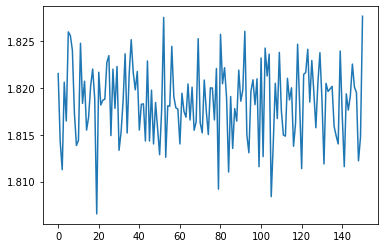

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.84it/s]


Epoch: 151, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.68it/s]


Epoch: 152, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.96it/s]


Epoch: 153, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.30it/s]


Epoch: 154, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.07it/s]


Epoch: 155, Loss: 1.83


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.02it/s]


Epoch: 156, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.78it/s]


Epoch: 157, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.20it/s]


Epoch: 158, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.88it/s]


Epoch: 159, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.25it/s]


Epoch: 160, Loss: 1.82


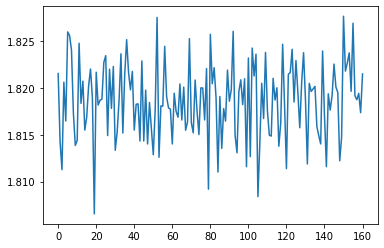

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 48.35it/s]


Epoch: 161, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.28it/s]


Epoch: 162, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 49.33it/s]


Epoch: 163, Loss: 1.83


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.47it/s]


Epoch: 164, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.86it/s]


Epoch: 165, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.56it/s]


Epoch: 166, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 48.49it/s]


Epoch: 167, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.79it/s]


Epoch: 168, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.61it/s]


Epoch: 169, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 42.59it/s]


Epoch: 170, Loss: 1.81


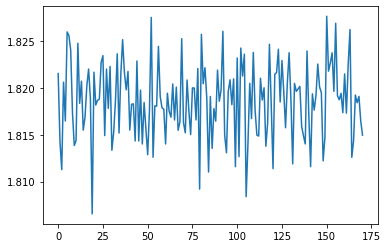

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.51it/s]


Epoch: 171, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.60it/s]


Epoch: 172, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.06it/s]


Epoch: 173, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.00it/s]


Epoch: 174, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.83it/s]


Epoch: 175, Loss: 1.83


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.96it/s]


Epoch: 176, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.98it/s]


Epoch: 177, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.68it/s]


Epoch: 178, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.94it/s]


Epoch: 179, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.13it/s]


Epoch: 180, Loss: 1.82


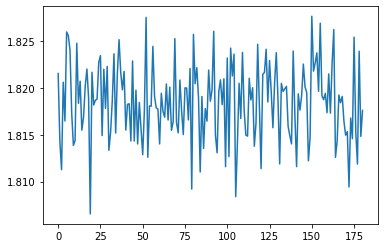

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.21it/s]


Epoch: 181, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 49.45it/s]


Epoch: 182, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.84it/s]


Epoch: 183, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 41.61it/s]


Epoch: 184, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.26it/s]


Epoch: 185, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 48.09it/s]


Epoch: 186, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.56it/s]


Epoch: 187, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.56it/s]


Epoch: 188, Loss: 1.83


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.49it/s]


Epoch: 189, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 48.63it/s]


Epoch: 190, Loss: 1.82


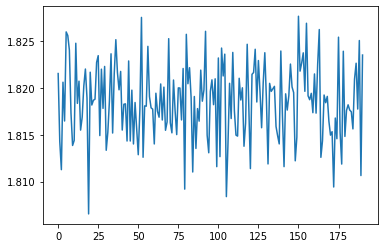

  0%|                                                                                            | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17836/3636619069.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)
100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 43.94it/s]


Epoch: 191, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.94it/s]


Epoch: 192, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 45.24it/s]


Epoch: 193, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 46.63it/s]


Epoch: 194, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.49it/s]


Epoch: 195, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 33.73it/s]


Epoch: 196, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.52it/s]


Epoch: 197, Loss: 1.81


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 38.38it/s]


Epoch: 198, Loss: 1.82


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.71it/s]

Epoch: 199, Loss: 1.82


In [214]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn, device):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    model.train()
    model.to(device)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        # pred = model(batch.x.float(), 
        #                         batch.edge_attr.float(),
        #                         batch.edge_index, 
        #                         batch.batch) 
        pred = model(batch.x, batch.edge_index, batch.batch)
        # print("pred", pred.T.shape,  batch.y.shape)
        # Calculating the loss and gradients
        loss = loss_fn(pred, batch.y)
        # print('Epoch: {}, Batch: {},  Loss: {:.2f}'.format(epoch, batch_idx, loss.item()))
        # print("LOSS", loss)
        loss.requires_grad = True
        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        # counting batches
        step += 1
    # loss average per epoch
    return running_loss/step

device = set_device_and_seed(GPU=True, seed=0)
plotting_dict_train = {}
plotting_dict_train['loss'] = []
plot_every = 10
num_epochs = 200
for i in range(num_epochs):
    loss = train_one_epoch(i, model, train_loader, optimizer, criterion, device)
    plotting_dict_train['loss'].append(loss)
    print('Epoch: {}, Loss: {:.2f}'.format(i, loss))
    if i % plot_every == 0:
        plt.figure()
        plt.plot(np.arange(len(plotting_dict_train['loss'])), plotting_dict_train['loss'])
        plt.show()
        

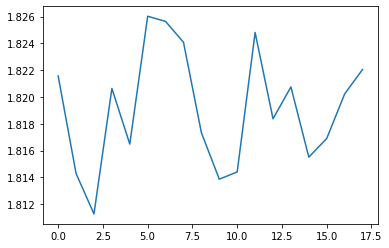

In [211]:
plt.figure()
plt.plot(np.arange(len(plotting_dict_train['loss'])), plotting_dict_train['loss'])